In [1]:
# To enable faster auto-complete
%config Completer.use_jedi = False

In [2]:
import os
import sys
import tensorflow as tf 
import re
import numpy as np
import eli5
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from eli5.sklearn import PermutationImportance
from tensorflow import keras
from eli5.permutation_importance import get_score_importances
from sklearn.utils import shuffle

In [3]:
# Selecting the GPU to be used 
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict tensor flow to use GPU-1
    try:
        tf.config.experimental.set_visible_devices([], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Set GPUs before initializing
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
4 Physical GPUs 0 Logical GPU


**Note**
- Some cells are converted to raw notebook and some are code cells
- The raw cells corresponds to particular type of model, so if you need to use those, convert them back to code cell from the raw cell
- Make sure the correct sets of cells are enabled before running the notebook

# Loading the data

## Seperate Model Data

- Data for the models if they were built seperately

## Multi-output model Data

- The model on the paper

In [4]:
# Directory of the dataset
data_dir = os.path.join(os.getcwd(), "model_data", "multi_output_axisfr")

for index1, file in enumerate(os.listdir(data_dir)):
    data = np.load(os.path.join(data_dir, file), allow_pickle=True)[()]
    
    for index2, ((axis, feed_rate), segmented_points) in enumerate(data.items()):
        
        temp_axis = np.repeat(axis, segmented_points.shape[0])[:, np.newaxis]
        temp_fr = np.repeat(feed_rate, segmented_points.shape[0])[:, np.newaxis]
    
        # part of X and y
        if index2 == 0:
            # part of y for an axis and all feed rate
            part_y_axis = temp_axis
            part_y_fr = temp_fr
            # part of X
            part_X = segmented_points
        else:
            part_y_axis = np.append(part_y_axis, temp_axis, axis=0)
            part_y_fr = np.append(part_y_fr, temp_fr, axis=0)
            part_X = np.append(part_X, segmented_points, axis=0)
            
    if index1 == 0:
        # y
        y_axis = part_y_axis
        y_fr = part_y_fr
        # X
        X = part_X
    else:
        y_axis = np.append(y_axis, part_y_axis, axis=0)
        y_fr = np.append(y_fr, part_y_fr, axis=0)
        X = np.append(X, part_X, axis=0)

# Loading the model

- Loading the model weights

## Seperate Model Weights
- If the models were developed seperately

## Multi-output model Weights

- The model in the paper

In [5]:
# Check the right model type
is_multi_output = True

# The folder time
folder_time = "2021-07-28T00:07:46.613812"

# Select the model to load
load_file = "multi-ouput_KFold-6_model.h5"
# Load the selected model 
model = keras.models.load_model(os.path.join(os.getcwd(), "model_weights", "multi_output_ax-fr", folder_time, load_file))
# Need compilation to change the accuracy metric - tensorflow issue
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss={"axis_detection": "sparse_categorical_crossentropy", "feed_rate_prediction": "mse"}, 
              metrics={"axis_detection": "accuracy"}, loss_weights=[1, 20])

# Baseline prediction

-  To verify the model's performance

## Seperate model prediction

## Multi-output model prediction

In [6]:
score = model.evaluate(X, {"axis_detection": y_axis, "feed_rate_prediction": y_fr})
sys.stdout.write("Baseline score: {}\n".format(score))

1521/1521 [==============================] - 18s 12ms/step - loss: 8100.0874 - axis_detection_loss: 0.1679 - feed_rate_prediction_loss: 399.0941 - axis_detection_accuracy: 0.9481
Baseline score: [8100.08740234375, 0.16791518032550812, 399.0941162109375, 0.9480511546134949]


# Permutation Importance

- Randomly permute the data. One column at a time
- Followed by making a prediction
- Determine the impact on the model's performance for each column that is permuted.

In [7]:
# Know the data
print("X: {}".format(X.shape))
print("y: {}".format(y.shape))

X: (48644, 85, 3)


In [8]:
# Dictionary of important features
feature_importance = {}

In [9]:
num_features = 3
feature_X_dict = {}
num_iterations = 10

# Run for certain number of iterations
for iteration in range(num_iterations):

    # Keep track of the features that are to be shuffled
    for index, feature_index in enumerate(range(num_features)):
        feature_X_dict[feature_index] = copy.deepcopy(X[:, :, feature_index])

    # Feature shuffling
    mod_feature_X_dict = {}
    temp = copy.deepcopy(feature_X_dict)
    for index, feature_index in enumerate(range(num_features)):

        # Select the feature to shuffle
        # Use deep copy else it will shuffle in place
        selected_feature = copy.deepcopy(feature_X_dict[feature_index])
        # Shuffle the selected feature
        np.random.shuffle(selected_feature)

        # Put the shuffled item back
        temp[feature_index] = selected_feature

        # Put the whole data in a dict
        mod_feature_X_dict[feature_index] = temp

        # Reset the temp
        temp = copy.deepcopy(feature_X_dict)


    # Compare the data to ensure it is all good
    # The original dictionary
    sys.stdout.write('Getting a value of 0.0 => arrays are similar\n')
    for feature_index in feature_X_dict.keys():
        sys.stdout.write(f"{feature_index} - {np.sum(X[:, :, feature_index] - feature_X_dict[feature_index])}\n")

    for feature_index in mod_feature_X_dict.keys():
        sys.stdout.write(f"=={feature_index}==\n")
        for feature_index2 in mod_feature_X_dict[feature_index].keys():
            sys.stdout.write(f"{feature_index} - {np.sum(X[:, :,feature_index2] - mod_feature_X_dict[feature_index][feature_index2])} || ")
        sys.stdout.write("\n")


    # Computing the score
    feature_importance[iteration+1] = {}
    for feature in range(num_features):

        # Select the data dict
        mod_X_dict = mod_feature_X_dict[feature]

        # Put the data together
        for key in sorted(mod_X_dict.keys()):
            if key == 0:
                mod_X = mod_X_dict[key][:, :, np.newaxis]
            else:
                mod_X = np.concatenate((mod_X, mod_X_dict[key][:, :, np.newaxis]), axis=2)

        # Predict the model
        if is_multi_output:
            columns = ["feature", "loss", "axis_detection_loss", "feed_rate_prediction_loss", "axis_detection_accuracy"]
            score = model.evaluate(mod_X, {"axis_detection": y_axis, "feed_rate_prediction": y_fr})
        else:
            columns = ["feature", "loss", "accuracy"]
            score = model.evaluate(mod_X, y)
        # Print the results
        print(f"Feature changed - {feature}; Score - {score}")

        feature_importance[iteration+1][feature] = score


Getting a value of 0.0 => arrays are similar
0 - 0.0
1 - 0.0
2 - 0.0
==0==
0 - 1.4097167877480388e-10 || 0 - 0.0 || 0 - 0.0 || 
==1==
1 - 0.0 || 1 - 6.775735528208315e-11 || 1 - 0.0 || 
==2==
2 - 0.0 || 2 - 0.0 || 2 - 2.9115199140505865e-10 || 
1521/1521 [==============================] - 18s 12ms/step - loss: 6118240.5000 - axis_detection_loss: 4.5056 - feed_rate_prediction_loss: 305905.7812 - axis_detection_accuracy: 0.2489
Feature changed - 0; Score - [6118240.5, 4.505624771118164, 305905.78125, 0.24893100559711456]
1521/1521 [==============================] - 18s 12ms/step - loss: 3932902.2500 - axis_detection_loss: 3.6286 - feed_rate_prediction_loss: 196638.9375 - axis_detection_accuracy: 0.3238
Feature changed - 1; Score - [3932902.25, 3.6285572052001953, 196638.9375, 0.3238426148891449]
1521/1521 [==============================] - 18s 12ms/step - loss: 2783420.0000 - axis_detection_loss: 3.2365 - feed_rate_prediction_loss: 139164.9375 - axis_detection_accuracy: 0.4175
Feature ch

In [10]:
# Convert to df to analyze the model's performance
feature_importance_list = []
for iteration in sorted(feature_importance.keys()):
    
    for index, (key, value) in enumerate(feature_importance[iteration].items()):
        temp1 = [key, value[0], value[1], value[2], value[3]]
        feature_importance_list.append(temp1)
        
feature_importance_df = pd.DataFrame(feature_importance_list, columns=columns)

In [11]:
# Describe summary statistics of the df
feature_importance_sum_stat = feature_importance_df.groupby(by="feature").describe()

In [12]:
# Stats
feature_importance_sum_stat

loss                                                       \
        count         mean           std         min           25%   
feature                                                              
0        10.0  6094313.500  21092.594281  6065800.00  6.075226e+06   
1        10.0  3938852.525  14167.170342  3920518.75  3.930727e+06   
2        10.0  2766209.525  30832.399343  2705059.75  2.744777e+06   

                                              axis_detection_loss            \
                50%           75%         max               count      mean   
feature                                                                       
0        6095944.00  6.112582e+06  6118240.50                10.0  4.521031   
1        3934570.25  3.941748e+06  3963174.50                10.0  3.634077   
2        2773909.00  2.791067e+06  2802940.25                10.0  3.246368   

         ... feed_rate_prediction_loss                axis_detection_accuracy  \
         ...                       75%            max                   count   
feature  ...                                                                    
0        ...             305622.820312  305905.781250                    10.0   
1        ...             197081.289062  198152.593750                    10.0   
2        ...             139547.226562  140140.859375                    10.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
feature                                                                        
0        0.247471  0.001575  0.244778  0.246459  0.247584  0.248643  0.249794  
1        0.322389  0.001810  0.319155  0.321499  0.322003  0.323519  0.325693  
2        0.417178  0.001040  0.415611  0.416598  0.417400  0.417580  0.418962  

[3 rows x 32 columns]

In [13]:
# Only for feedrate prediction
feature_importance_sum_stat["feed_rate_prediction_loss"]

,count,mean,std,min,25%,50%,75%,max
feature,,,,,,,,
0,10.0,304709.415625,1054.608345,303283.40625,303755.414062,304790.953125,305622.820312,305905.781250
1,10.0,196936.562500,708.254734,196020.06250,196530.574219,196722.390625,197081.289062,198152.593750
2,10.0,138304.414062,1541.569769,135247.06250,137232.816406,138689.437500,139547.226562,140140.859375


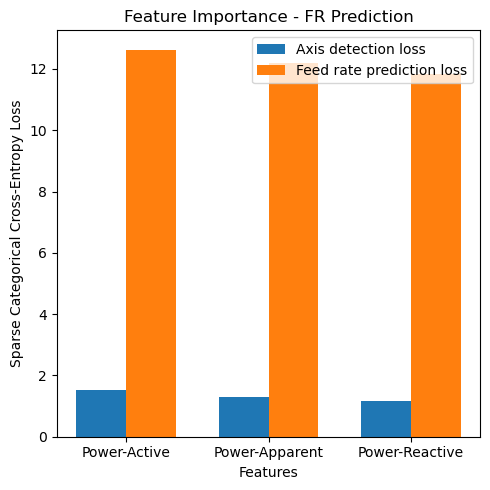

In [32]:
# Set the font properties
matplotlib.rcdefaults()
font = {'size'   : 10.0}
matplotlib.rc('font', **font)

labels = ["Power-Active", "Power-Apparent", 'Power-Reactive']
x = np.arange(3) # Label locations
width = 0.35

fig, ax = plt.subplots(figsize=(5, 5))

# Bar chart
rects1 = ax.bar(x - width/2, np.log(feature_importance_sum_stat["axis_detection_loss"]["mean"]), width=0.35, label="Axis detection loss")
rects2 = ax.bar(x + width/2, np.log(feature_importance_sum_stat["feed_rate_prediction_loss"]["mean"]), width=0.35, label="Feed rate prediction loss")
ax.set_xlabel("Features")
ax.set_ylabel("Sparse Categorical Cross-Entropy Loss")
ax.set_title("Feature Importance - FR Prediction")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
fig.savefig("feature_imp.png", bbox_inches="tight")